#### * Reference: https://keras.io/examples/vision/siamese_network/

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
import sys
import sklearn as sk
from IPython.display import Image, display
from pathlib import Path
from tqdm import tqdm
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import model_from_json

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.4.1
Keras Version: 2.4.0
Python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.3
GPU is available


In [3]:
df = pd.read_csv('./Dataset/train.csv')
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [4]:
imgs_df = pd.read_csv('triplets_imgs_data_3.csv')
imgs_df = imgs_df.drop(columns=['pos_lbl_grp', 'neg_lbl_grp'])
imgs_df.head(2)

,anchor,positive,negative
0,1d7aadc7503b2b4539cc9a5fe41979dd.jpg,3301b8aaccea93d1098995ffbc537335.jpg,076f457afa2e1ef8ee007b4789ed0473.jpg
1,1d7aadc7503b2b4539cc9a5fe41979dd.jpg,eec692257e74fcbc6cb63cb76d0f20e7.jpg,6e67961a76a784af596481de0edbefc9.jpg


In [5]:
img_phash_df = pd.read_csv('triplets_img_phash_data_3.csv')
img_phash_df.head(2)

,anchor,positive,negative,pos_lbl_grp,neg_lbl_grp
0,e925873ed09cd08f,e9b5833e929e909c,e679998c9b328e8c,258047,2269100299
1,e925873ed09cd08f,ea97861c926a71e3,ab5af9da9290da48,258047,2911345952


In [6]:
title_df = pd.read_csv('triplets_title_data_3.csv')
title_df.head(2)

,anchor,positive,negative,pos_lbl_grp,neg_lbl_grp
0,Sarung celana wadimor original 100% dewasa dan...,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,NACIFIC FRESH HERB ORIGIN CLEANSING FOAM 150ML,258047,2269100299
1,Sarung celana wadimor original 100% dewasa dan...,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,GORDEN SMOKRING + PONI MOTIF EMBOSS POLOS WARN...,258047,2911345952


In [7]:
images_path = os.getcwd() + '\\Dataset\\train_images'
image_phash_path = os.getcwd() + '\\Dataset\\train_images'
title_phash_path = os.getcwd() + '\\Dataset\\train_images'

#### * Generating Image embeddings: 

In [8]:
target_shape = (128, 128)
batch_size = 128

In [9]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [10]:
anchor_images = [images_path+'\\'+i for i in list(imgs_df['anchor'])]
positive_images = [images_path+'\\'+i for i in list(imgs_df['positive'])]
negative_images = [images_path+'\\'+i for i in list(imgs_df['negative'])]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

print(anchor_dataset, positive_dataset, negative_dataset)

<TensorSliceDataset shapes: (), types: tf.string> <TensorSliceDataset shapes: (), types: tf.string> <TensorSliceDataset shapes: (), types: tf.string>


In [11]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)
print(dataset)

<MapDataset shapes: ((128, 128, 3), (128, 128, 3), (128, 128, 3)), types: (tf.float32, tf.float32, tf.float32)>


In [12]:
image_count = len(anchor_images)

train_dataset = dataset.take(round(image_count * 0.7)).batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)
train_dataset = train_dataset.cache()

val_dataset = dataset.skip(round(image_count * 0.7)).batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)
val_dataset = val_dataset.cache()

print(train_dataset, '\n', val_dataset)

<CacheDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32, tf.float32)> 
 <CacheDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32, tf.float32)>


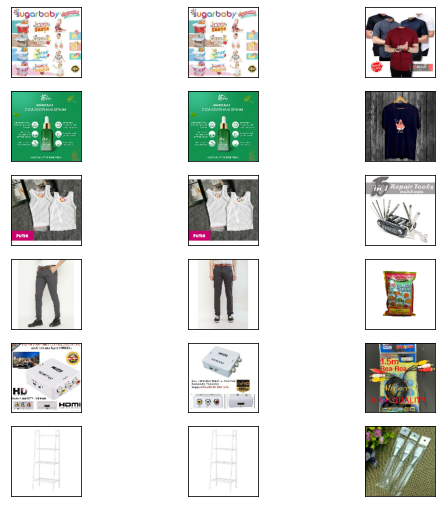

In [13]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(6, 3)
    for i in range(6):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [14]:
base_cnn = resnet.ResNet50(weights="imagenet", input_shape=target_shape + (3,), include_top=False, pooling='avg')
dropout = layers.Dropout(0.2, input_shape=(2,))(base_cnn.output)
output = layers.Dense(512, activation="linear")(dropout)

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable
    
embedding = Model([base_cnn.input], output, name="Embedding")

In [15]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)


siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [16]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 128, 128, 3)  0           anchor[0][0]                     
______________________________________________________________________________________________

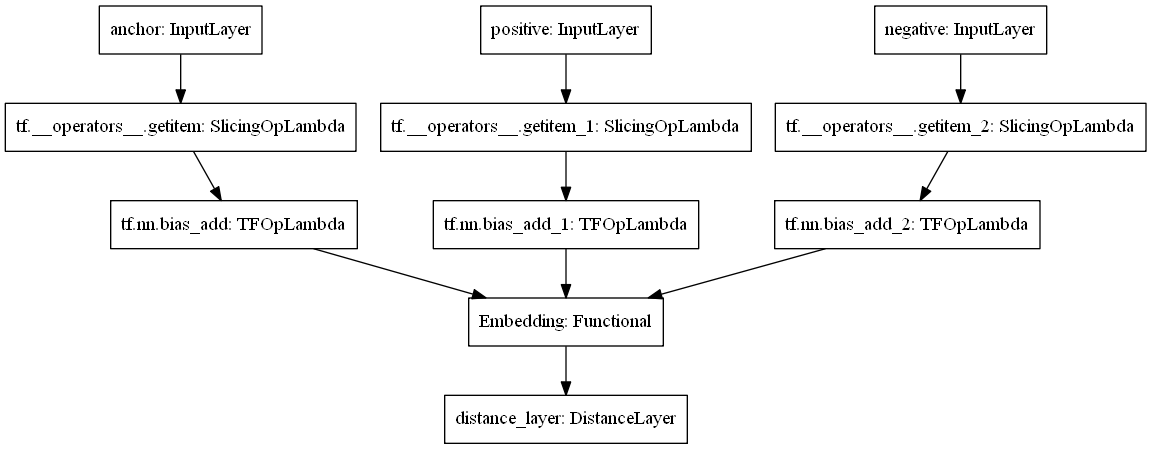

In [17]:
tf.keras.utils.plot_model(siamese_network)

In [18]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [19]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [20]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[earlystop], verbose=1)

Epoch 1/50
181/181 [==============================] - 909s 5s/step - loss: 0.1350 - val_loss: 0.1176
Epoch 2/50
181/181 [==============================] - 61s 338ms/step - loss: 0.1060 - val_loss: 0.1129
Epoch 3/50
181/181 [==============================] - 63s 349ms/step - loss: 0.0932 - val_loss: 0.1083
Epoch 4/50
181/181 [==============================] - 62s 341ms/step - loss: 0.0827 - val_loss: 0.1058
Epoch 5/50
181/181 [==============================] - 62s 345ms/step - loss: 0.0716 - val_loss: 0.1108
Epoch 6/50
181/181 [==============================] - 63s 348ms/step - loss: 0.0630 - val_loss: 0.1152
Epoch 7/50
181/181 [==============================] - 62s 346ms/step - loss: 0.0578 - val_loss: 0.1165
Epoch 8/50
181/181 [==============================] - 63s 351ms/step - loss: 0.0507 - val_loss: 0.1295
Epoch 9/50
181/181 [==============================] - 65s 358ms/step - loss: 0.0460 - val_loss: 0.1197
Epoch 10/50
181/181 [==============================] - 63s 349ms/step - los

In [33]:
embedding_json = siamese_model.siamese_network.get_layer('Embedding').to_json()

with open('embedding_model.json','w') as json_file:
    json_file.write(embedding_json)
    
siamese_model.siamese_network.get_layer('Embedding').save_weights('embedding_wtgs.h5')

In [27]:
json_file = open('embedding_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

ld_embedding_model = model_from_json(loaded_model_json)

ld_embedding_model.load_weights("embedding_wtgs.h5")

In [32]:
iterator = iter(train_dataset)
cosine_similarity = metrics.CosineSimilarity()

pos_sim = []
neg_sim = []

for i in tqdm(range(100)):
    sample = next(iterator)
#     visualize(*sample)
    
    anchor, positive, negative = sample
    anchor_embedding, positive_embedding, negative_embedding = (
        ld_embedding_model(preprocess_input(anchor)),
        ld_embedding_model(preprocess_input(positive)),
        ld_embedding_model(preprocess_input(negative)),
    )
    
    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    pos_sim.append(positive_similarity)
#     print("Positive similarity:", positive_similarity.numpy())
    
    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    neg_sim.append(negative_similarity)
#     print("Negative similarity", negative_similarity.numpy())
    
print('Mean Pos.', np.median(pos_sim))
print('Mean Neg.', np.median(neg_sim))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

Mean Pos. 0.987128
Mean Neg. 0.9870373


In [ ]:
img_values = (images_path + '\\' + df['image']).values
predict_embeddings = []

for i in tqdm(img_values):
    img = tf.reshape(preprocess_image(i), (-1,) + target_shape + (3,))
    predict_embeddings.append(embedding(resnet.preprocess_input(img)))

In [ ]:
with open('predict_embeddings.pkl','wb') as f:
    pickle.dump(predict_embeddings, f)

In [ ]:
# with open('predict_embeddings.pkl','rb') as f:
#     predict_embeddings = pickle.load(f)

In [ ]:
predict_vectors = np.vstack(predict_embeddings)

In [ ]:
res_df = df.copy()
res_df.head(2)

In [ ]:
knn_model = NearestNeighbors(n_neighbors=50, metric='cosine')
knn_model.fit(predict_vectors)

In [ ]:
# Reference: https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700

preds = []
CHUNK = 1024*4

print('Finding similar images...')

CTS = len(predict_vectors)//CHUNK

if len(predict_vectors)%CHUNK!=0: 
    CTS += 1
    
for j in range(CTS):
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(predict_vectors))
    print('chunk',a,'to',b)
    distances, indices = knn_model.kneighbors(predict_vectors[a:b,])
    for k in range(b-a):
        IDX = np.where(distances[k,]<0.001)[0]
        IDS = indices[k,IDX]
        o = res_df.iloc[IDS].posting_id.values
        preds.append(o)

In [ ]:
res_df['pred'] = preds
res_df.head()

In [ ]:
test_df = pd.read_csv('./Dataset/test.csv')
test_df.head()

In [ ]:
test_images_path = os.getcwd() + '\\Dataset\\test_images'

test_img_values = (test_images_path + '\\' + test_df['image']).values
test_predict_embeddings = []

for i in tqdm(test_img_values):
    img = tf.reshape(preprocess_image(i), (-1,) + target_shape + (3,))
    test_predict_embeddings.append(embedding(resnet.preprocess_input(img)))

In [ ]:
test_predict_vectors = np.vstack(test_predict_embeddings)

In [ ]:
test_knn_model = NearestNeighbors(n_neighbors=2, metric='cosine')
test_knn_model.fit(test_predict_vectors)

In [ ]:
# Reference: https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700

test_preds = []
CHUNK = 1024*4

print('Finding similar images...')

CTS = len(test_predict_vectors)//CHUNK

if len(test_predict_vectors)%CHUNK!=0:
    CTS += 1
    
for j in range( CTS ):
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test_predict_vectors))
    print('chunk',a,'to',b)
    distances, indices = test_knn_model.kneighbors(test_predict_vectors[a:b,])
    
    for k in range(b-a):
        IDX = np.where(distances[k,] <0.001)[0]
        IDS = indices[k,IDX]
        o = test_df.iloc[IDS].posting_id.values
        test_preds.append(o)

In [ ]:
test_df['pred'] = test_preds
test_df.head()

In [ ]:
def get_matches(x):
    print(x)
    return (' '.join(x))

test_df['pred'] = test_df['pred'].apply(lambda x : get_matches(x))

In [ ]:
submission = pd.DataFrame(list(zip(list(test_df['posting_id']), list(test_df['pred']))), columns=['posting_id', 'matches'])
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()